- 이미지에서 물체의 위치 추정 (회귀)
    - 물체 주위의 바운딩 박스 예측 방법
        - 수평 좌표
        - 수직 좌표
        - 높이
        - 너비
    - 전역 평균 풀링층 위에 4개의 유닛을 갖는 두 번째 밀집 출력 층을 추가하고, MSE 손실을 사용해 훈련

#### **데이터 로드 및 전처리**

In [8]:
import tensorflow as tf
from tensorflow import keras

In [4]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)  # with_info=True : 데이터셋에 대한 정보
dataset_size = info.splits["train"].num_examples 
class_names = info.features["label"].names  
n_classes = info.features["label"].num_classes 

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [5]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [6]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

In [7]:
batch_size = 32   # 배치 크기 지정
train_set = train_set_raw.shuffle(1000)   # 훈련 데이터 shuffle

train_set = train_set_raw.map(preprocess).batch(batch_size).prefetch(1)   # 프리페치 적용
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

#### **모델 생성, 컴파일**

In [10]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)

model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],
              optimizer=optimizer, metrics=["accuracy"])

#### **Labeling 문제점**
- 꽃 데이터셋은 꽃 주위에 바운딩 박스를 갖고 있지 않기 때문에 **직접 만들어서 추가**하는 작업 필요
- 이미지에 바운딩 박스를 추가하기 위한 오픈 소스 이미지 레이블 도구
    - VGG Image Annotator, LabelImg, OpenLabeler, ImgLab
    - LabelBox, Supervisely
    - 크라우드소싱 플랫폼

- 바운딩 박스 추가
    - 데이터셋 형태 : (images, (class_labels, bounding_boxes))

In [11]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

In [13]:
fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [14]:
fake_train_set

<MapDataset shapes: ((None, 224, 224, 3), ((None,), (None, 4))), types: (tf.float32, (tf.int64, tf.float32))>

#### **손실 함수**
- 바운딩 박스 예측 평가 지표 : IoU
- 예측한 바운딩 박스와 타깃 바운딩 박스 사이에 중첩되는 영역을 전체 영역으로 나눈 값
- tf.keras.metrics.MeanIoU  
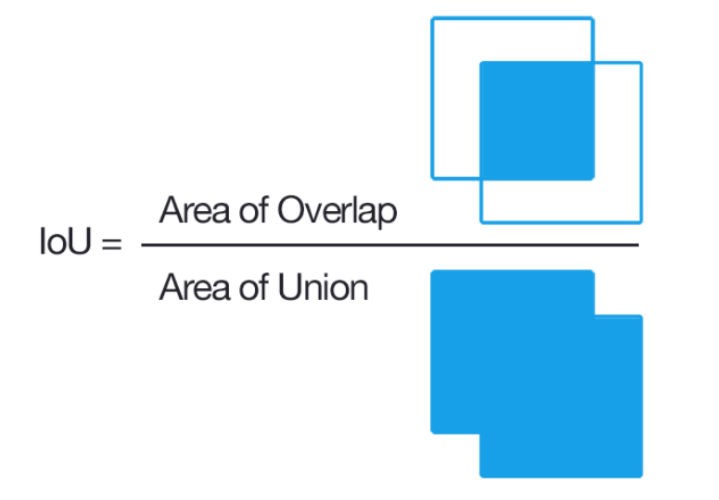